### Pull MongoDB data


In [1]:
import os
import datetime as dt
import pandas as pd
import csv

In [2]:
# add the 'src' directory as one where we can import modules
import sys
import pathlib # __file__ isn't recognized in Jupyter, so we need this to get the root path
path = pathlib.Path.cwd()
PROJ_ROOT = path.parent 
src_dir = str(PROJ_ROOT / 'src')
PROJ_ROOT = str(PROJ_ROOT)
sys.path.append(src_dir)
# from data import make_dataset

In [3]:
from data import user_df_setup

interim_data_file_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim",
                                 "full_users_df.pkl")
# users_df = pd.read_pickle(interim_data_file_path)
raw_data_file_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw",
                             "users_df.pkl")
raw_users_df = pd.read_pickle(raw_data_file_path)

all_users_df = user_df_setup.user_df_setup(raw_data_file_path, interim_data_file_path)

users_df = all_users_df
# raw_users_df
# raw_users_df[['username', 'timeCreated']].sort_values('timeCreated', ascending = False).head(20)
all_users_df.sort_values('date_created', ascending = False).head(5)
# all_users_df.index
# all_users_df.head(20)

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
davidt,2019-04-16,NaN,5cb60fc57aeafc0011cec7b2,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0
doyle coleman,2019-03-19,NaN,5c90fb30939ba200110ff237,0.0,1.0,3.0
driverseat,2019-03-19,NaN,5c90fa54939ba200110ff229,0.0,1.0,3.0
blonco,2019-03-19,NaN,5c90f9ea683da8001107a5af,0.0,1.0,3.0


In [4]:
raw_users_df.head()

,_id,email,encPrivateKey,isActive,nonce,password,phone,publicKey,resetPassword,roles,salt,timeCreated,username
0,b'000000000000000000000000',ben@heycharlie.org,NaN,True,NaN,testtest,NaN,NaN,NaN,"{'admin': {'id': '111111111111111111111111', '...",NaN,2018-04-30 23:35:08.686,root
1,b'5aebcb8cc0162e0010966860',test@test.com,VebxgFshaTyTg8wpDrpCOlpc5pLVVYej2zgxjwHLcw3Gi+...,True,pJeaY6YKlC1c+OFASB18TJxFX5y96ftR,G+bswA3ItAMw3oXjuws8D6g+eqeBYVFhC4zvO6jrypM=,NaN,TIAvK31iVaq+MP7MEQxZSm5nWuQU6hhbK/B+Im6CNyo=,NaN,"{'account': {'id': '5aebcb8cc0162e0010966861',...",oBmQD+ttaZQhmHa8111qcQ,2018-05-04 02:55:08.094,kb8yqz3n2abcpvaab2e89sqmomkkhh2oxmzuzdnwxno=
2,b'5b0d91a3876ddd001af27ccb',vinny@heycharlie.org,LEWeFmRca1OY2My0ZlR6NgkQCTA49oZDPmhKkS1qw6vXvf...,True,ho12imIpU/A5Cg+m83oplDvrD+Piom9T,PxkjZMc9akPjtMVr0ppfC9Ssh3bsYFZjfYggqm8xM88=,NaN,Iu+Tg0/3ZKvvjGYp59TCkCbjJFJLEIsHqmjSlxjhCVo=,NaN,"{'account': {'id': '5b0d91a3876ddd001af27ccc',...",10VG3hX6pvEB3f3UscBYZw,2018-05-29 17:45:07.795,clse0aafjxsiz7zeupwwnfolygdxcfnd6uitdtmlzuq=
3,b'5b198f09dfd99a00113eefcd',,RFlhZib7Nf4ipi0PplmF/oVY/TKP8FkUwIg2NjIUCRoHei...,True,KzH0HRQgVB6a0Oe7gN8HXbsT0NxOrpZx,dXSnWovEn7xabEBJ74qyYcV4/L+kcOmjHkFZIZXjtO0=,NaN,ExgPvruUDTIuvVfkK9H9OWWKwRIBvwi2RiBy8/UuPQ8=,NaN,"{'account': {'id': '5b198f09dfd99a00113eefce',...",/ZR2yufr0qYCDtS04WqOUA,2018-06-07 20:01:13.564,test
4,b'5b23b05adfd99a00113eefd9',,8s1gII2EA3gHp4m/PYn2CPG4M6zt0rAg9/8Z+pTW612mOj...,True,MVdc/EQfFdOA0NTo8iKX11RbDEDbnMmK,zPNeQ0Y7Lvh3fk0jHWqHOPDK4mQJUKD/0eBPW1clJHE=,NaN,qV5Mn+OkTB3TQJgcBybc0X1zDUpBbAWXdoVuDqJAX0g=,NaN,"{'account': {'id': '5b23b05adfd99a00113eefda',...",oO1xUOoAKZrZiT0Lp/z16A,2018-06-15 12:26:02.396,emily


In [5]:
current_users = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
user_ids = all_users_df['userId'].tolist()
print(len(user_ids))
# user_ids

136


## Set Usernames of Interest

In [6]:
usernames = current_users.index
usernames = ['pinky618','vinnov10', 'davidt', 'doyle coleman']
demo_username = 'pinky618'

### Force-pulling Contacts data from MongoDB

In [7]:
from data import database_query

raw_data_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw")
# current_users_df = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
current_users_df = all_users_df[all_users_df.index.isin(usernames)]
user_ids = current_users_df['userId'].tolist()
database_query.make_raw_contacts_df(database_query.mongo_connect(),
                                   raw_data_path,
                                   user_ids)

In [8]:
current_users_df

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
vinnov10,2018-11-10,NaN,5be764b71e71cc00160ef263,0.0,1.0,3.0
doyle coleman,2019-03-19,NaN,5c90fb30939ba200110ff237,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0
davidt,2019-04-16,NaN,5cb60fc57aeafc0011cec7b2,0.0,1.0,3.0


,objectId,objectType,timestamp,type
479,None,None,2019-03-20 17:38:10.730,daily-task-question
480,5c9a35e238e41c2fdd5061ac,contactLog,2019-03-26 10:23:32.234,outgoing-call-warning
481,5c9a431838e41c2fdd5061b3,contactLog,2019-03-26 11:19:54.224,outgoing-call-warning
482,5c9a436c38e41c2fdd5061b5,contactLog,2019-03-26 11:21:18.086,outgoing-call-warning
483,5c9a43ae38e41c2fdd5061b7,contactLog,2019-03-26 11:22:24.255,outgoing-call-warning


### Force-creating Contacts interim data

In [10]:
from data import contacts_df_setup
from data import user_df_setup

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
contacts_dict = {}

for username in usernames: 
    interim_contact_data_file_path = os.path.join(interim_data_path, 'contacts_df_' + username + '.pkl')
    if os.path.isfile(interim_contact_data_file_path):
        contacts_df = pd.read_pickle(interim_contact_data_file_path)
    else:
        current_users_df = user_df_setup.user_df_setup(os.path.join(raw_data_path, 'users_df.pkl'),
                                               os.path.join(interim_data_path, 'users_df.pkl'))
        contacts_df = contacts_df_setup.contacts_df_setup(username,
                                                          current_users_df,
                                                          raw_data_path,
                                                          interim_data_path)
    contacts_dict[username] = contacts_df

In [11]:
contacts_dict['vinnov10'].head(40)

,score,relationship,question 1,question 2,question 3,question 4,question 5,question 6,question 7,question 8
_id,,,,,,,,,,
5be7689916f7bb00169daf1c,2.922871,family,1.0,0.0,2.88,3.44,3.04,2.68,2.6,1.0
5be7689b1e71cc00160ef26d,-1.000000,family,0.0,0.0,1.44,1.2,-1.0,-1.0,-1.0,-1.0
5be7689c16f7bb00169daf1d,-1.000000,family,0.0,0.0,1.88,1.96,-1.0,-1.0,-1.0,-1.0
5be7689c16f7bb00169daf1e,2.172047,friend,1.0,0.0,2.36,2.84,2.44,2.36,2.68,1.52
5be7689e1e71cc00160ef26e,-1.000000,friend,0.0,2.0,2.0,2.12,-1.0,-1.0,-1.0,-1.0
5be7689f1e71cc00160ef26f,-1.000000,risky,0.0,0.0,2.6,2.72,-1.0,-1.0,-1.0,-1.0
5be771d10eb5fd0010495d4c,0.806557,risky,1.0,0.0,4.0,0.2,0.4,0.2,0.24,0.2
5be7be8d1dc2970010696d30,-1.000000,family,0.0,0.0,0.12,1.16,-1.0,-1.0,-1.0,-1.0
5be849521dc2970010696d59,-1.000000,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    contacts_dict[e]['risk_assignment'] = None
    
    contacts_dict[e].loc[((contacts_df['score'] < unrated_threshold)
                    & (contacts_df['relationship'] != 'risky')),'risk_assignment'] = 'unrated'
#     unrated = contacts_df['score'][(contacts_df['score'] < unrated_threshold)
#                                   & (contacts_df['relationship'] != 'risky')]
#     print(contacts_dict[e].head())
    contacts_dict[e].loc[((contacts_df['relationship'] == 'risky')
                        | ((contacts_df['score'] >= unrated_threshold)
                            & (contacts_df['score'] <= risky_threshold))), 'risk_assignment'] = 'risky'
#     risky = contacts_df['score'][(contacts_df['relationship'] == 'risky')
#                                 | ((contacts_df['score'] >= unrated_threshold)
#                                 & (contacts_df['score'] <= risky_threshold))]
    
    contacts_dict[e].loc[((contacts_df['score'] > risky_threshold)
                        & (contacts_df['score'] < supportive_threshold)
                        & (contacts_df['relationship'] != 'risky')), 'risk_assignment'] ='neutral'
#     neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
#                                 & (contacts_df['score'] < supportive_threshold)]
    
    contacts_dict[e].loc[((contacts_df['score'] >= supportive_threshold)
                        & (contacts_df['relationship'] != 'risky')), 'risk_assignment'] ='supportive'
#     supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
# contacts_dict['+vinny'].head(10)

In [13]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    unrated = contacts_df['score'][(contacts_df['risk_assignment'] == 'unrated')]
    risky = contacts_df['score'][(contacts_df['risk_assignment'] == 'risky')]
    neutral = contacts_df['score'][(contacts_df['risk_assignment'] == 'neutral')]
    supportive = contacts_df['score'][(contacts_df['risk_assignment'] == 'supportive')]
    
    axarr[count, 0].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count, 0].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count, 0].bar(risky.index, risky, 0.7, color = '#ff6600')
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count, 0].set_title(e + ' - rated: ' + str(len(contacts_df) - len(unrated)) + ' unrated: ' + str(len(unrated)))
    
    # unrelated, pulling the counts
#     current_users_df.loc[e, 'unrated_contacts'] = len(unrated)
#     current_users_df.loc[e, 'risky_contacts'] = len(risky)
#     current_users_df.loc[e, 'neutral_contacts'] = len(neutral)
#     current_users_df.loc[e, 'supportive_contacts'] = len(supportive)
#     current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']
# current_users_df
plt.show()

<Figure size 1000x1600 with 4 Axes>

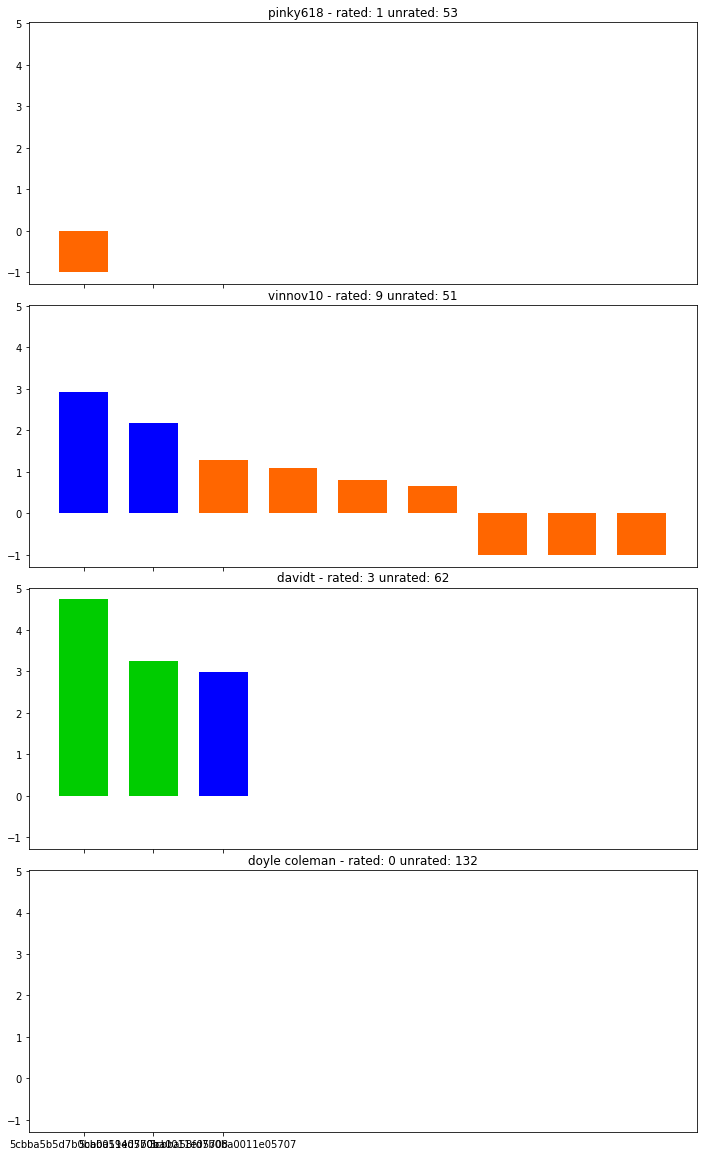

In [14]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    unrated = contacts_df['score'][(contacts_df['score'] < unrated_threshold)
                                  & (contacts_df['relationship'] != 'risky')]
    risky = contacts_df['score'][(contacts_df['relationship'] == 'risky')
                                | ((contacts_df['score'] >= unrated_threshold)
                                & (contacts_df['score'] <= risky_threshold))]
    neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
                                & (contacts_df['score'] < supportive_threshold)]
    supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
    
    axarr[count, 0].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count, 0].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count, 0].bar(risky.index, risky, 0.7, color = '#ff6600')
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count, 0].set_title(e + ' - rated: ' + str(len(contacts_df) - len(unrated)) + ' unrated: ' + str(len(unrated)))
    
# current_users_df.head()
# plt.show()

c:\users\vinny\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\vinny\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, 'Rated Contacts by Type')

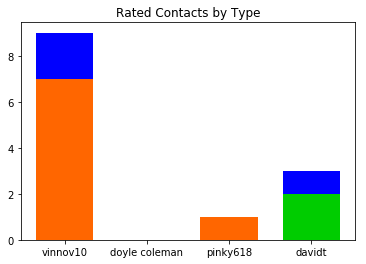

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
# plt.tight_layout()
fig = plt.figure()
ax = fig.add_subplot(111)

for count, e in enumerate(usernames):  
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    current_users_df.loc[e, 'unrated_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'unrated'])
    current_users_df.loc[e, 'risky_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'risky'])
    current_users_df.loc[e, 'neutral_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'neutral'])
    current_users_df.loc[e, 'supportive_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'supportive'])
    current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']

# for count, e in enumerate(usernames):     
ax.bar(current_users_df.index, current_users_df['risky_contacts'], 0.7, color = '#ff6600')
ax.bar(current_users_df.index, current_users_df['supportive_contacts'], 0.7, color = '#00cc00', bottom=current_users_df['risky_contacts'])
ax.bar(current_users_df.index, current_users_df['neutral_contacts'], 0.7, color = 'b', bottom=np.array(current_users_df['supportive_contacts'])+np.array(current_users_df['risky_contacts'])) 
# ax.bar(current_users_df.index, current_users_df['unrated_contacts'], 0.7, color = '#C0C0C0', bottom=current_users_df['neutral_contacts'])
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
ax.set_title('Rated Contacts by Type')

# plt.show()

Text(0.5, 1.0, 'Contacts by Relationship')

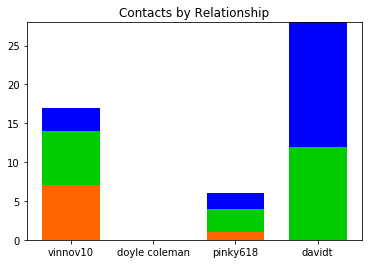

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
# plt.tight_layout()
fig = plt.figure()
ax = fig.add_subplot(111)

for count, e in enumerate(usernames):  
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    current_users_df.loc[e, 'family_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'family')
                                                                & (contacts_df['risk_assignment'] != 'risky')])
    current_users_df.loc[e, 'friend_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'friend')
                                                                & (contacts_df['risk_assignment'] != 'risky')])
    current_users_df.loc[e, 'risky_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'risky')
                                                                | (contacts_df['risk_assignment'] == 'risky')])
    current_users_df.loc[e, 'other_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'other')
                                                                & (contacts_df['risk_assignment'] != 'risky')])
#     current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']

# for count, e in enumerate(usernames):     
ax.bar(current_users_df.index, current_users_df['risky_contacts'], 0.7, color = '#ff6600')
ax.bar(current_users_df.index, current_users_df['family_contacts'], 0.7, color = '#00cc00', bottom=current_users_df['risky_contacts'])
ax.bar(current_users_df.index, current_users_df['friend_contacts'], 0.7, color = 'b', bottom=np.array(current_users_df['family_contacts'])+np.array(current_users_df['risky_contacts'])) 
ax.bar(current_users_df.index, current_users_df['other_contacts'], 0.7, color = '#C0C0C0', bottom=np.array(current_users_df['friend_contacts'])+np.array(current_users_df['family_contacts'])+np.array(current_users_df['risky_contacts'])) 
# ax.bar(current_users_df.index, current_users_df['unrated_contacts'], 0.7, color = '#C0C0C0', bottom=current_users_df['neutral_contacts'])
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
ax.set_title('Contacts by Relationship')

# plt.show()

In [17]:
contacts_df = contacts_dict['davidt']
contacts_df[contacts_df['score'] != -1]

,score,relationship,question 1,question 2,question 3,question 4,question 5,question 6,question 7,question 8,risk_assignment
_id,,,,,,,,,,,
5cbba58fd7b0ba0011e05707,2.976263,family,1.0,0.0,3.0,3.0,3.8,2.84,2.88,1.32,neutral
5cbba594d7b0ba0011e05708,3.244557,friend,1.0,0.0,3.96,2.92,3.92,1.12,2.84,0.92,supportive
5cbba5b5d7b0ba0011e0570b,4.738095,family,1.0,0.0,2.92,3.88,4.0,4.0,2.96,0.48,supportive


### Force Creating Comm Data

In [18]:
from data import comm_df_analyses

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
comm_dict = {}
missing_comm_users = []
for username in usernames: 
#     if username not in current_users_df.index:
#         print(username + ' not in current_users_df')
#         missing_comm_users.append(username)
#         continue
        
#     interim_comm_data_file_path = os.path.join(interim_data_path, 'day_comm_log_df_' + username + '.pkl')
#     if os.path.isfile(interim_comm_data_file_path):
#         daily_comm_df = pd.read_pickle(interim_comm_data_file_path)
#         daily_comm_dict[username] = daily_comm_df
        
    interim_comm_data_file_path = os.path.join(interim_data_path, 'comm_log_df_' + username + '.pkl')
    if os.path.isfile(interim_comm_data_file_path):
        comm_df = pd.read_pickle(interim_comm_data_file_path)
    else:
        comm_df = comm_df_analyses.comm_df_setup(username,
                                              current_users_df,
                                              contacts_dict[username],
                                              raw_data_path,
                                              interim_data_path)
    comm_dict[username] = comm_df
# print(missing_comm_users)
# usernames = list(set(usernames) - set(missing_users))
comm_dict[demo_username].head()

,contactId,direction,risk_score,relationship
timestamp,,,,
2019-03-20 13:12:40.579,5c92a26c683da8001107a635,phone_finished,-1.0,family
2019-03-20 13:29:07.314,5c92a26c683da8001107a635,phone_finished,-1.0,family
2019-03-20 13:30:31.936,5c92a26c683da8001107a635,phone_finished,-1.0,family
2019-03-20 13:32:14.954,5c92a26c683da8001107a635,phone_finished,-1.0,family
2019-03-20 14:03:58.797,5c92b8ce939ba200110ff2be,sms_received,-1.0,none


#### Pulling daily comm by contact

In [19]:
day_contact_comm_dict = {}
for username in usernames: 
    day_contact_comm_df = comm_df_analyses.contact_time_bucket_comm(username,
                                                               users_df,
                                                               contacts_dict[username],
                                                               comm_dict[username],
                                                               interim_data_path,
                                                               'day')
    day_contact_comm_dict[username] = day_contact_comm_df
# print(str(len(day_contact_comm_dict['+vinny'].columns)) + ' # of contacts')
day_contact_comm_dict[demo_username].head()

_id,5c92a26c683da8001107a635,5c92a26f939ba200110ff2bb,5c92a271939ba200110ff2bc,5c92a277683da8001107a636,5c92a27a683da8001107a637,5c92a287939ba200110ff2bd,5c92b8ce939ba200110ff2be,5c93cc96683da8001107a63e,5c94efb2939ba200110ff2c8,5c953bdf939ba200110ff2d0,...,outbound_5cc468841c1de9001128f1f1,inbound_5cc502f1f9142d0011788518,outbound_5cc502f1f9142d0011788518,inbound_5cc719d3529f250011f249d9,outbound_5cc719d3529f250011f249d9,inbound_5cc7219d529f250011f249db,outbound_5cc7219d529f250011f249db,inbound_5cc729e8529f250011f249dd,outbound_5cc729e8529f250011f249dd,total_comm
2019-03-20,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2019-03-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-22,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,6.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0
2019-03-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2019-03-24,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


Text(0.5, 1.0, 'pinky618')

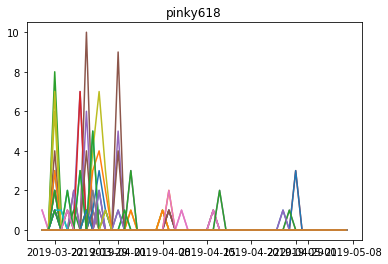

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(day_contact_comm_dict[demo_username].drop('total_comm', axis=1))
ax.set_title(demo_username)


In [21]:
# current_users[['date_created', 'unrated_contacts', 'risky_contacts', 'neutral_contacts', 'supportive_contacts', 'rated_contacts']]
# current_users

In [22]:
# import numpy as np

# for username in usernames: 
#     if username in notification_dict.keys():
#         notifications_df = notification_dict[username]
#         current_users.loc[username, 'notifications'] = len(notifications_df.index)
#     else:
#         current_users.loc[username, 'notifications'] = 0

### SQL Analyses

In [23]:
from data import firebase_sql_queries

client = firebase_sql_queries.init_sql_connection()

In [24]:
reviver_events_dict = {}
for username in usernames:
    print(username)
    if username == 'pinky618':
        sql_username = 'Pinky618 '
    elif username == 'davidt':
        sql_username == 'DavidT'
    else:
        sql_username = username

    reviver_events = firebase_sql_queries.get_reviver_events(client, sql_username)
    reviver_events.index = pd.to_datetime(reviver_events['timestamp'], unit="us") - dt.timedelta(hours=4)
    reviver_events = reviver_events.drop(columns='timestamp')
    
    reviver_events_dict[username] = reviver_events
reviver_events_dict[demo_username].head(15)

pinky618
vinnov10
davidt
doyle coleman


,event
timestamp,
2019-04-28 07:58:32.756003,reviver_scimitar_already_running
2019-04-28 07:58:31.798002,reviver_scimitar_already_running
2019-04-28 07:58:31.528001,reviver_scimitar_already_running
2019-04-27 21:33:38.161004,reviver_scimitar_already_running
2019-04-27 21:33:37.843003,reviver_scimitar_already_running
2019-04-27 21:33:37.132001,reviver_scimitar_already_running
2019-04-26 15:58:09.537010,reviver_scimitar_already_running
2019-04-26 15:58:09.466009,reviver_scimitar_already_running
2019-04-26 15:58:09.040006,reviver_scimitar_already_running


#### time bucketing reviver events

In [25]:
# def time_bucket_comm(username, users_df, comm_df, interim_data_path, period):
daily_activity_dict = {}
for username in usernames:
    print(username)
    today = dt.date.today()
    reviver_events = reviver_events_dict[username]
    date_created = all_users_df.loc[username, 'date_created']
    date_indices = pd.date_range(date_created, today + dt.timedelta(7), freq='D')

    activity_columns = ['reviver_scimitar_already_running', 'reviver_scimitar_starting']
    daily_activity_df = pd.DataFrame(np.nan, index=date_indices, columns=activity_columns)

    for j in activity_columns:
        data = reviver_events[reviver_events['event'] == j]
        col_name = j
        if len(data) > 0:  # not sure if this is necessary
            temp = data.groupby(pd.cut(data.index, daily_activity_df.index, right=False)).agg({'event': pd.Series.count})
            temp.columns = [col_name]
            temp = temp.reset_index()
            temp.index = temp['index'].apply(lambda x: x.left)
            daily_activity_df[col_name] = temp[col_name]
    daily_activity_df = daily_activity_df.fillna(0)
    daily_activity_dict[username] = daily_activity_df

daily_activity_dict[demo_username].head(10)

pinky618
vinnov10
davidt
doyle coleman


,reviver_scimitar_already_running,reviver_scimitar_starting
2019-03-20,3.0,0.0
2019-03-21,14.0,0.0
2019-03-22,53.0,3.0
2019-03-23,0.0,2.0
2019-03-24,18.0,3.0
2019-03-25,27.0,0.0
2019-03-26,12.0,0.0
2019-03-27,20.0,0.0
2019-03-28,33.0,0.0
2019-03-29,12.0,0.0


### Daily frequency of reviver_scimitar_already_running

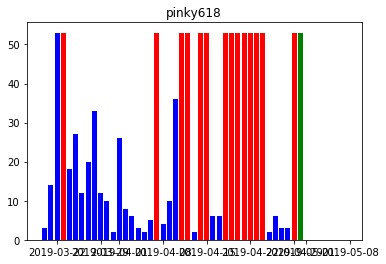

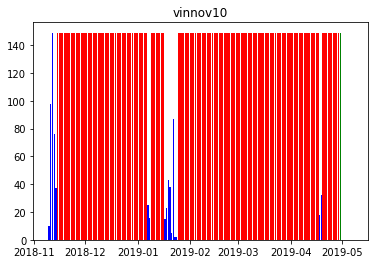

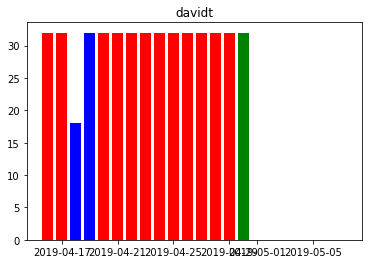

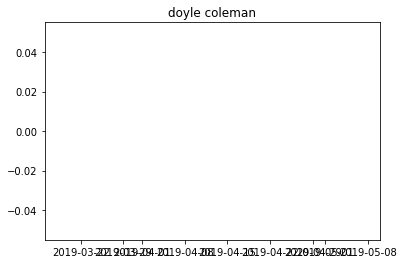

In [26]:
for count, username in enumerate(usernames):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    activity_columns = ['reviver_scimitar_already_running', 'reviver_scimitar_starting']
    data = daily_activity_dict[username][activity_columns[0]]
    
    today = dt.date.today()
    zero_data = data[data == 0]
    zero_data = zero_data[:today] + max(data)
    
    ax.bar(data.index, data, color='b')
    ax.bar(zero_data.index, zero_data, color='r')
    ax.bar(today,max(data), color='g')
    ax.set_title(username)
plt.show()

In [27]:
# pull_contact_questionnaire(username, user_id, contacts, raw_data_path, interim_data_path):
question_numbers = np.arange(1,9)
questions = []
for e in question_numbers:  
    questions.append("question " + str(e))

for username in usernames:
    print(username)
    contacts = contacts_dict[username]
    user_id = current_users_df.loc[username, 'userId']
    raw_data_file_path = os.path.join(raw_data_path, 'questionnaire_df_' + user_id + '.pkl')
    raw_questionnaires_df = pd.read_pickle(raw_data_file_path)
    
    if len(raw_questionnaires_df) == 0:
        # the thing
        for i in questions:
            for index, row in contacts.iterrows():
                contacts.loc[index, i] = np.nan
    else:
        for index, row in contacts.iterrows():
            contact_id = index
            questionnaires = raw_questionnaires_df[raw_questionnaires_df["contactId"] == contact_id]
            if len(questionnaires) == 0:
                pass
                # do the thing
            else:
                current_questionnaire = questionnaires.loc[questionnaires['timestamp'].idxmax()]
#                 print(current_questionnaire['questions'])
                for e in current_questionnaire['questions']:
#                     print(e)
                    question_id = "question " + str(e['questionId'])
                    contacts.loc[contact_id,question_id] = e['answer']
        
#         print(contacts)
    interim_data_file_path = os.path.join(interim_data_path, 'contacts_df_' + username + '.pkl')
    contacts.to_pickle(interim_data_file_path)        

pinky618
vinnov10
davidt
doyle coleman


### Notifications

In [28]:
from data import notifications_df_setup

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
notification_dict = {}
# missing_comm_users = []
for username in usernames: 
#     if username not in current_users_df.index:
#         print(username + ' not in current_users_df')
#         missing_comm_users.append(username)
#         continue
        
#     interim_comm_data_file_path = os.path.join(interim_data_path, 'day_comm_log_df_' + username + '.pkl')
#     if os.path.isfile(interim_comm_data_file_path):
#         daily_comm_df = pd.read_pickle(interim_comm_data_file_path)
#         daily_comm_dict[username] = daily_comm_df
        
    interim_notification_data_file_path = os.path.join(interim_data_path, 'notifications_log_df_' + username + '.pkl')
    if os.path.isfile(interim_notification_data_file_path):
        notification_df = pd.read_pickle(interim_notification_data_file_path)
    else:
        notification_df = notifications_df_setup.notifications_df_setup(username,
                                                              current_users_df,
                                                              raw_data_path,
                                                              interim_data_path)
    notification_dict[username] = notification_df
# print(missing_comm_users)
# usernames = list(set(usernames) - set(missing_users))
notification_dict[demo_username].head()

,objectId,objectType,timestamp,type
479,None,None,2019-03-20 17:38:10.730,daily-task-question
480,5c9a35e238e41c2fdd5061ac,contactLog,2019-03-26 10:23:32.234,outgoing-call-warning
481,5c9a431838e41c2fdd5061b3,contactLog,2019-03-26 11:19:54.224,outgoing-call-warning
482,5c9a436c38e41c2fdd5061b5,contactLog,2019-03-26 11:21:18.086,outgoing-call-warning
483,5c9a43ae38e41c2fdd5061b7,contactLog,2019-03-26 11:22:24.255,outgoing-call-warning
